In [1]:
import pyvisa
import datetime
import json
import time
import numpy as np
import matplotlib.pyplot as plt

In [58]:
# Connect to keithleys
rm = pyvisa.ResourceManager()
print(rm.list_resources())

emitter = rm.open_resource('GPIB1::10::INSTR')
extractor = rm.open_resource('GPIB1::11::INSTR')
gate = rm.open_resource('GPIB1::9::INSTR')

print("Using " + emitter.query('*IDN?'))
print("Using " + extractor.query('*IDN?'))
print("Using " + gate.query('*IDN?'))

('TCPIP0::18.25.29.125::inst0::INSTR', 'TCPIP0::K-CX3300-ERIAL.local::hislip0::INSTR', 'TCPIP0::K-CX3300-ERIAL.local::inst0::INSTR', 'ASRL1::INSTR', 'ASRL4::INSTR', 'GPIB1::9::INSTR', 'GPIB1::10::INSTR', 'GPIB1::11::INSTR')
Using Keithley Instruments Inc., Model 2657A, 1409197, 1.2.0

Using Keithley Instruments Inc., Model 2657A, 4033749, 1.1.8

Using Keithley Instruments Inc., Model 2657A, 1409200, 1.1.8



In [59]:
emitter.write('smua.reset()')
extractor.write('smua.reset()')
gate.write('smua.reset()')

14

In [141]:
# experiment_name = 'test'
data_dir = 'C://Users//kashkin//Desktop//keithley data//'
current_limit = 1.0e-3
notes = '1e-7 torr'
trace_resistance = 15000
iterates = 5
data_points = 46
voltage_limit = 2200
upper_voltage = -900
gate_voltage_input = 100
measurement_count = 1
filter_measurement_count = 5
experiment_name = 'tuball 631e mozzarella x{iterates} {upper_voltage} upper voltage {gate_voltage} v gate'.format(iterates=iterates, upper_voltage=upper_voltage, gate_voltage=gate_voltage_input)
nplc = 1 # nplc/60 is the period of the measurement
input_voltages = list(np.linspace(0, upper_voltage, num=data_points))

# input_voltages = list(np.linspace(0, upper_voltage, num=data_points)) + list(np.linspace(upper_voltage,0,num=data_points))

In [142]:
# Configure as voltage source
emitter.write(' \
    smua.source.func = smua.OUTPUT_DCVOLTS \n\
    display.smua.measure.func = display.MEASURE_DCAMPS \n\
    smua.measure.autozero = smua.AUTOZERO_AUTO \n\
    smua.measure.autorangei = smua.AUTORANGE_OFF \n\
    smua.measure.rangei = {i_lim} \n\
    smua.measure.rangev = {v_lim} \n\
    smua.source.limiti = {i_lim} \n\
    smua.measure.adc = smua.ADC_INTEGRATE \n\
    smua.measure.nplc = {nplc} \n\
    smua.measure.delay = smua.DELAY_OFF \n\
    smua.measure.count = {m_count} \n\
    smua.measure.filter.count = {f_count} \n\
    smua.measure.filter.enable = smua.FILTER_ON \n\
    smua.measure.filter.type = smua.FILTER_REPEAT_AVG \
    '.format(i_lim = current_limit, v_lim = voltage_limit, m_count = measurement_count, nplc=nplc, f_count = filter_measurement_count))

579

In [143]:
# Configure as voltage source
extractor.write(' \
    smua.source.func = smua.OUTPUT_DCVOLTS \n\
    display.smua.measure.func = display.MEASURE_DCAMPS \n\
    smua.measure.autozero = smua.AUTOZERO_AUTO \n\
    smua.measure.autorangei = smua.AUTORANGE_OFF \n\
    smua.measure.rangei = {i_lim} \n\
    smua.measure.rangev = {v_lim} \n\
    smua.source.limiti = {i_lim} \n\
    smua.measure.adc = smua.ADC_INTEGRATE \n\
    smua.measure.nplc = {nplc} \n\
    smua.measure.delay = smua.DELAY_OFF \n\
    smua.measure.count = {m_count} \n\
    smua.measure.filter.count = {f_count} \n\
    smua.measure.filter.enable = smua.FILTER_ON \n\
    smua.measure.filter.type = smua.FILTER_REPEAT_AVG \
    '.format(i_lim = current_limit, v_lim = voltage_limit, m_count = measurement_count, nplc=nplc, f_count = filter_measurement_count))

579

In [144]:
# Configure as voltage source
gate.write(' \
    smua.source.func = smua.OUTPUT_DCVOLTS \n\
    display.smua.measure.func = display.MEASURE_DCAMPS \n\
    smua.measure.autozero = smua.AUTOZERO_AUTO \n\
    smua.measure.autorangei = smua.AUTORANGE_OFF \n\
    smua.measure.rangei = {i_lim} \n\
    smua.measure.rangev = {v_lim} \n\
    smua.source.limiti = {i_lim} \n\
    smua.measure.adc = smua.ADC_INTEGRATE \n\
    smua.measure.nplc = {nplc} \n\
    smua.measure.delay = smua.DELAY_OFF \n\
    smua.measure.count = {m_count} \n\
    smua.measure.filter.count = {f_count} \n\
    smua.measure.filter.enable = smua.FILTER_ON \n\
    smua.measure.filter.type = smua.FILTER_REPEAT_AVG \
    '.format(i_lim = current_limit, v_lim = voltage_limit, m_count = measurement_count, nplc=nplc, f_count = filter_measurement_count))

579

In [145]:
aggregate_data = {'notes':notes}
for i in range(iterates):
    aggregate_data['iterate_{i}'.format(i=i)] = {'input_voltages':[],'input_gate_voltages':[],'measured_emitter_voltages':[],'measured_extractor_voltages':[],'emitter_currents':[],'extractor_currents':[],'measured_gate_voltages':[],'gate_currents':[],'times':[]}

In [146]:
# Conduct iteration of voltages applied to emitter with extractor set as ground
start_time = float(datetime.datetime.now().timestamp())
for i in range(iterates):
    for voltage in input_voltages:
        emitter.write('smua.source.levelv = %s'%voltage)
        extractor.write('smua.source.levelv = 0')
        gate.write('smua.source.levelv = %s'%gate_voltage_input)

        emitter.write('ireading, vreading = smua.measure.iv(smua.nvbuffer1, smua.nvbuffer2)')
        extractor.write('ireading, vreading = smua.measure.iv(smua.nvbuffer1, smua.nvbuffer2)')
        gate.write('ireading, vreading = smua.measure.iv(smua.nvbuffer1, smua.nvbuffer2)')

        emitter_current = float(emitter.query("print(ireading)")[:-1])
        emitter_voltage = float(emitter.query("print(vreading)")[:-1])

        extractor_current = float(extractor.query("print(ireading)")[:-1])
        extractor_voltage = float(extractor.query("print(vreading)")[:-1])

        gate_current = float(gate.query("print(ireading)")[:-1])
        gate_voltage = float(gate.query("print(vreading)")[:-1])

        aggregate_data['iterate_{i}'.format(i=i)]['input_voltages'].append(voltage)
        aggregate_data['iterate_{i}'.format(i=i)]['input_gate_voltages'].append(gate_voltage)
        aggregate_data['iterate_{i}'.format(i=i)]['measured_emitter_voltages'].append(emitter_voltage)
        aggregate_data['iterate_{i}'.format(i=i)]['measured_extractor_voltages'].append(extractor_voltage)
        aggregate_data['iterate_{i}'.format(i=i)]['measured_gate_voltages'].append(gate_voltage)
        aggregate_data['iterate_{i}'.format(i=i)]['emitter_currents'].append(emitter_current)
        aggregate_data['iterate_{i}'.format(i=i)]['extractor_currents'].append(extractor_current)
        aggregate_data['iterate_{i}'.format(i=i)]['gate_currents'].append(gate_current)
        aggregate_data['iterate_{i}'.format(i=i)]['times'].append(float(datetime.datetime.now().timestamp()) - start_time)

emitter.write('smua.source.levelv = 0')
extractor.write('smua.source.levelv = 0')
gate.write('smua.source.levelv = 0')


24

0.10713619656032985
9.333913580149229


(array([15.,  0.,  0.,  0., 18., 10.,  0.,  0.,  0.,  2.]),
 array([0.09998488, 0.10199208, 0.10399928, 0.10600648, 0.10801368,
        0.11002088, 0.11202807, 0.11403527, 0.11604247, 0.11804967,
        0.12005687]),
 <BarContainer object of 10 artists>)

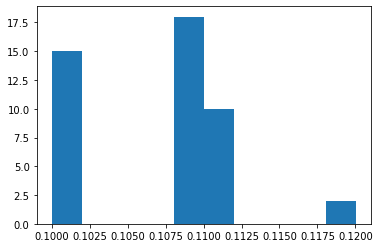

In [147]:
dts = []
for i in range(len(aggregate_data['iterate_1']['times']) - 1):
    dts.append(aggregate_data['iterate_1']['times'][i+1] - aggregate_data['iterate_1']['times'][i])
print(np.average(dts))
print(1/np.average(dts))
plt.hist(dts)

In [148]:
plt.show()

In [149]:
filename = data_dir + experiment_name + '_ %s'%datetime.datetime.now().strftime('%Y_%m_%d-%H_%M_%S') + '.json'

with open(filename, 'w') as file:
    json.dump(aggregate_data, file)

print('saved to %s' %{filename})

saved to {'C://Users//kashkin//Desktop//keithley data//tuball 631e mozzarella x5 -900 upper voltage 100 v gate_ 2022_11_21-17_37_05.json'}


In [150]:
resistances = []
for i in range(iterates):
    sample_count = 5
    start_sample = 10
    for j in range(start_sample,start_sample+sample_count):
        measured_current = float(aggregate_data['iterate_{i}'.format(i=i)]['emitter_currents'][j])
        voltage = float(aggregate_data['iterate_{i}'.format(i=i)]['input_voltages'][j])
        if measured_current:
            resistance = voltage/measured_current
            resistances.append(resistance)

measured_trace_resistance = sum(resistances)/len(resistances)
print(measured_trace_resistance)

2737716217.47032


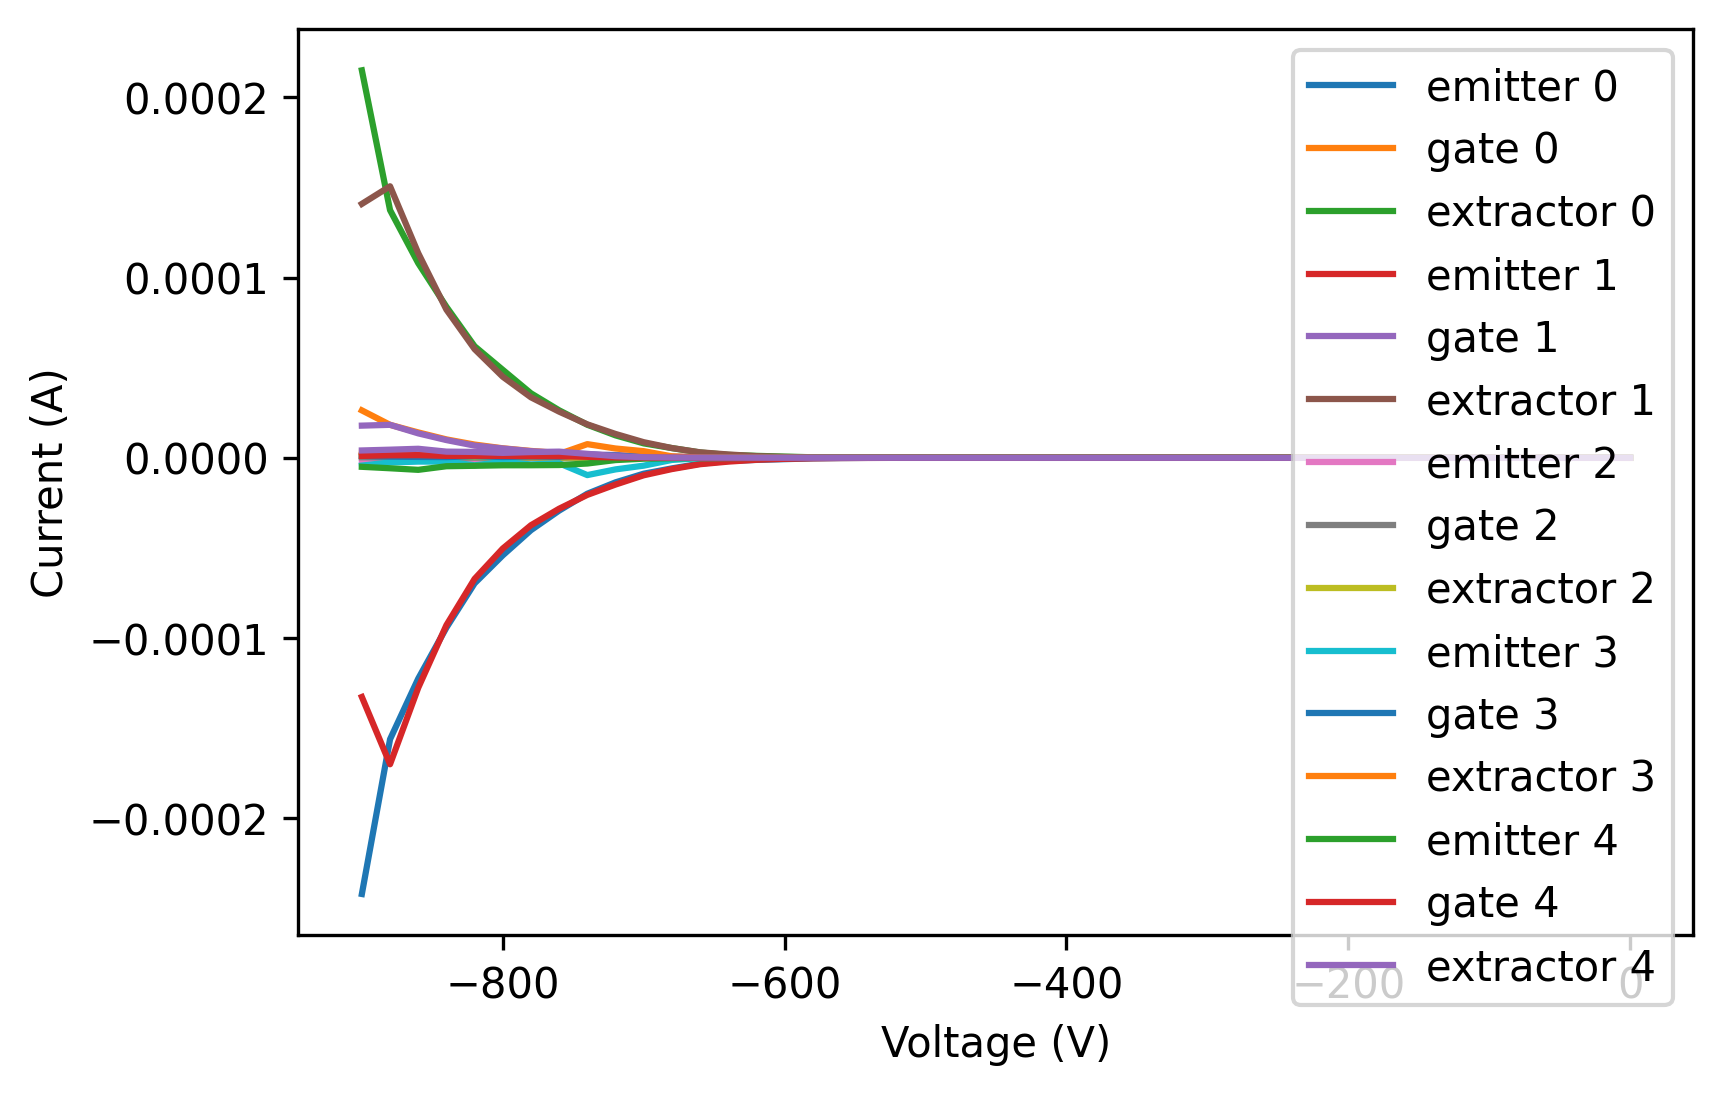

In [151]:
plt.figure(dpi=300)
for i in range(0, iterates):
    input_voltages = aggregate_data['iterate_{i}'.format(i=i)]['input_voltages']
    aggregate_currents = aggregate_data['iterate_{i}'.format(i=i)]['emitter_currents']
    current_from_resistance = [0 for j in input_voltages]
    fe_currents = []
    for k in range(len(input_voltages)):
        fe_currents.append(aggregate_currents[k] - current_from_resistance[k])
    plt.plot(input_voltages, fe_currents,label='emitter %s'%i)
    gate_currents = aggregate_data['iterate_{i}'.format(i=i)]['gate_currents']
    plt.plot(input_voltages, gate_currents, label='gate %s'%i)
    extractor_currents = aggregate_data['iterate_{i}'.format(i=i)]['extractor_currents']
    plt.plot(input_voltages, extractor_currents, label='extractor %s'%i)

plt.xlabel('Voltage (V)')
plt.ylabel('Current (A)')
# plt.ylim(-1e-6,1e-6)
# plt.yscale('log')
plt.legend()
plt.show()

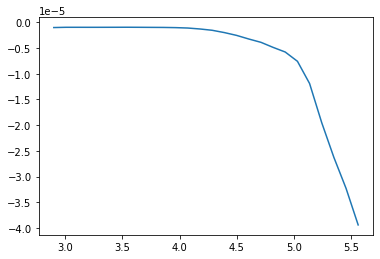

In [907]:
plt.plot(aggregate_data['iterate_1']['times'],aggregate_data['iterate_1']['extractor_currents'])
plt.show()

In [152]:
#Turn off output and drain capacitors
print("\nSetting source voltage to 0 V")
emitter.write("smua.source.levelv = 0")
extractor.write("smua.source.levelv = 0")

print("Turning off output")
emitter.write("smua.source.output = 0")
extractor.write("smua.source.output = 0")

print("Closing Keithley connection")
emitter.close()
extractor.close()


Setting source voltage to 0 V
Turning off output
Closing Keithley connection
